<a href="https://colab.research.google.com/github/HzcIrving/DeepLearning_PlayGround/blob/main/TransformerBasic/Transformer%E5%9F%BA%E7%A1%80%E5%AE%9E%E7%8E%B0StepByStep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transformer的实现，配合Notion笔记的学习，实现过程
- Transformer最流行的变体Variant就是BERT(Bidirectional Encoder Representations from Transformers)
- 预训练的BERT是最常用于替代embedding层的； 

## 数据集准备


In [ ]:
!pip3 install spacy

In [ ]:
!python3 -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 1.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
!python3 -m spacy download de_core_news_sm

     |████████████████████████████████| 14.9 MB 693 kB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-py3-none-any.whl size=14907055 sha256=6559b8cb31f670d648808977c3b946823fb33392914b4318325cca1fe87ecb98
  Stored in directory: /tmp/pip-ephem-wheel-cache-ct47e4b5/wheels/00/66/69/cb6c921610087d2cab339062345098e30a5ceb665360e7b32a
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


In [ ]:
import torch 
import torch.nn as nn 
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import de_core_news_sm
import en_core_web_sm
import numpy as np

import random
import math
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 创建tokenizers

分词的目的就是把“You are my friends” -> ["You","are","my","friends"]

英文分词就确实贼简单，一个空格分就完事了，但中文分词就不是了，首先的问题就是python也看不懂中文，不知咋分。另外，如果单纯的变成【“你”，“是”，“我”，“的”，“朋”，“友”】，那么会导致一个问题，汉字介么多，你的词典就需要很大很大，我们更希望要那些高频的，然后某些文字是固定成一个词语的，至少朋友得搞在一起吧：）【“你”，“是”，“我”，“的”，“朋友”】

这个时候你就需要用上开源的分词工具，在这里我们用的是spacy

In [ ]:
spacy_de = de_core_news_sm.load() #German 
spacy_en = en_core_web_sm.load() #English 

In [ ]:
def tokenize_de(text):
  """
  Tokenizes German text from a string into a list of strings
  """
  return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
  """
  Tokenizes English text from a string into a list of strings
  """
  return [tok.text for tok in spacy_en.tokenizer(text)]

torchtext的Field可以方便地处理数据。

我们把原始数据“德语”以及目标数据“英语”加上初始和结束的标志和, 然后把每个单词变成小写：

In [ ]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [ ]:
TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

### 读取Multi30k数据集，并创建词库

Multi30k数据集
我们直接采用torchtext里面自带的Multi30k


```
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),fields = (SRC, TRG))
```



In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),  fields = (SRC, TRG))

downloading training.tar.gz


100%|██████████| 1.21M/1.21M [00:02<00:00, 590kB/s]


downloading validation.tar.gz


100%|██████████| 46.3k/46.3k [00:00<00:00, 91.0kB/s]


downloading mmt_task1_test2016.tar.gz


100%|██████████| 66.2k/66.2k [00:00<00:00, 85.2kB/s]


build_vocab
接下来我们就需要根据原数据和目标数据建立词典了。因为我们需要为每个单词对应一个数字，

In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

### 定义data iterator 

iterators
类似于图像当中把图像数据集放到dataloader里面，文本信息采用的是torchtext里面的BucketIterator. 

train_data可以看上面的例子，就是一串数组。这个迭代器主要的两个功能：
- 根据我们之前建立好的词典把对应的单词转换成数字，并且转换为Tensor张量
- 它会建立batches，建立的这个batch可以减少填充padding的数量，包括原数据和目标数据


In [ ]:
BATCH_SIZE = 128 
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

### 可视化数据封装

In [ ]:
batch_idx = 1 
count  = 0 
data = next(iter(train_iterator)) 
for idx in data.src[:,batch_idx].cpu().numpy():
  count += 1 
  print(SRC.vocab.itos[idx],end=' ') 
print("German Example Length:",count) 
count = 0 
print()
for idx in data.trg[:,batch_idx].cpu().numpy():
  count += 1 
  print(TRG.vocab.itos[idx],end=' ') 
print("Eng Example Length:",count)

### 查看数据的封装形式

In [ ]:
for i, it in enumerate(iter(train_iterator)):
  if i > 10:
    break 
  src = it.src # German 
  trg = it.trg # Eng 
  print(src.shape, trg.shape)

## 模型构建--Encoder


### Basic EncoderLayer  
1. MultiHead-SelfAttentionLayer 
2. LayerNorm 
3. positionwise_feedforward 
4. Skipconnect

#### MultiHead Attention Layer

In [ ]:
class MultiHeadAttentionLayer(nn.Module): 
  def __init__(self, hid_dim, n_heads, dropout, device):
    super().__init__()
    
    assert hid_dim % n_heads == 0
    
    self.hid_dim = hid_dim
    self.n_heads = n_heads
    self.head_dim = hid_dim // n_heads
    
    # Q 
    self.fc_q = nn.Linear(hid_dim, hid_dim) 
    # K
    self.fc_k = nn.Linear(hid_dim, hid_dim) 
    # V 
    self.fc_v = nn.Linear(hid_dim, hid_dim)
    
    self.fc_o = nn.Linear(hid_dim, hid_dim)
    
    self.dropout = nn.Dropout(dropout)
    
    self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device) 
  
  def forward(self,query,key,value,mask=None):
    batch_size = query.shape[0] 

    # query:[bs x query_len x hid_dim] 
    # key :[bs x key_len x hid_dim]
    # value:[bs x value_len x hid_dim] 

    #Q = [batch size, query len, hid dim]
    #K = [batch size, key len, hid dim]
    #V = [batch size, value len, hid dim] 
    Q = self.fc_q(query)  
    K = self.fc_k(key)
    V = self.fc_v(value)  


    # dims:[batchsize, n_heads, length, hid_dim/n_heads]
    Q = Q.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3)
    K = K.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3) 
    V = V.view(batch_size,-1,self.n_heads,self.head_dim).permute(0,2,1,3) 

    # dims:[bs, n_heads, query_length, key_length]
    energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale 

    # Mask Operation: 防止影响softmax的输出结果
    if mask is not None:
      energy = energy.masked_fill(mask==0,-1e10)
    
    # Softmax 
    # dim:[bs, n_heads, query_length, key_length]
    attention = torch.softmax(energy,dim=-1) 

    # dim:[bs, n_heads, query_length, key_length] * [bs, n_heads, length, head_dims=hid_dim/n_heads]
    # dim:[bs, n_heads, length, head_dims]
    x = torch.matmul(self.dropout(attention),V)  
    # dim:[bs, length, n_heads, head_dims]
    x = x.permute(0,2,1,3).contiguous()  
    # dims:[bs, length, n_heads*head_dims]
    x = x.view(batch_size, -1, self.hid_dim)

    x = self.fc_o(x) 

    return x, attention

#### Position-wise FeedForward Layer 

In [ ]:
# 就是Fully Connected Layer 
class PositionwiseFeedforwardLayer(nn.Module):
  def __init__(self, hid_dim, pf_dim, dropout):
    super().__init__()
    
    self.fc_1 = nn.Linear(hid_dim, pf_dim)
    self.fc_2 = nn.Linear(pf_dim, hid_dim)
    
    self.dropout = nn.Dropout(dropout)
        
  def forward(self, x):
      
    #x = [batch size, seq len, hid dim]
    x = self.dropout(torch.relu(self.fc_1(x)))
    #x = [batch size, seq len, pf dim]
    x = self.fc_2(x)
    #x = [batch size, seq len, hid dim]
    return x

#### EncoderLayer --- Block

In [ ]:
class EncoderLayer(nn.Module):
  """Block"""
  def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
    super().__init__() 
    self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
    self.ff_layer_norm = nn.LayerNorm(hid_dim)
    self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
    self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout) 

    self.dropout = nn.Dropout(dropout) 
  
  def forward(self,src,src_mask):
    #src = [batch size, src len, hid dim]
    #src_mask = [batch size, 1, 1, src len]  
    
    # Multi-head self attention 
    # query,key,value,mask=None
    _src, _ = self.self_attention(src,src,src,src_mask) 

    # dropout, residual connection, layer norm 
    # dims: [bs, src_len, hid_dim] 
    src = self.self_attn_layer_norm(src+self.dropout(_src))   

    # FC 
    _src = self.positionwise_feedforward(src) 

    # dropout, residual connection, layer norm 
    src = self.ff_layer_norm(src + self.dropout(_src))

    return src

### 总体结构

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length=100):
    super().__init__() 
    self.device = device 

    # 字嵌入
    self.tok_embedding = nn.Embedding(input_dim,hid_dim)  
    # 位置嵌入  
    # 我们采用的是learned positional embeddings即可学习的位置编码 （与BERT一样）
    self.pos_embedding = nn.Embedding(max_length,hid_dim) 

    # Encoder Block  
    # Encoder Layer 复用 
    self.layers = nn.ModuleList([EncoderLayer(hid_dim,n_heads,pf_dim,dropout,device) for _ in range(n_layers)])

    self.dropout = nn.Dropout(dropout) 

    self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device) 

  def forward(self, src, src_mask):
    # src: [bs, src_len] 
    # src_mask: [bs, 1, 1, src_len] 

    batch_size = src.shape[0] 
    src_len = src.shape[1] 

    # [src_length]->[1,src_length]->[bs,src_length] same dimension as src 
    pos = torch.arange(0,src_len).unsqueeze(0).repeat(batch_size,1).to(self.device) 
    src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))   
    for layer in self.layers: 
      # 会看到输入的所有token，其中由于输入的句子小于我们固定好的长度的时候，
      # 会有这个token,这个时候我们是不希望输入的单词关注到它的，所以当token为的时候，
      # 我们会使用这个mask，令这个的value为0，否则都为1
      src = layer(src,src_mask)   
    return src

## Decoder

### Decoder Layer --- Block

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
    super().__init__()
    
    self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
    self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
    self.ff_layer_norm = nn.LayerNorm(hid_dim)
    self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
    self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
    self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
    self.dropout = nn.Dropout(dropout) 

  def forward(self,trg,enc_src,trg_mask,src_mask):
    #trg = [batch size, trglen, hid dim]
    #enc_src = [batch size, srclen, hid dim]
    #trg_mask = [batch size, 1, 1, trglen]
    #src_mask = [batch size, 1, 1, srclen] 
    
    # self attention 
    _trg, _ = self.self_attention(trg, trg, trg, trg_mask)  

    # dropout, residual connection and layer norm
    # trg = [batch size, trg len, hid dim]
    trg = self.self_attn_layer_norm(trg + self.dropout(_trg)) 

    # encoder_attention (Q,K) 
    # query: trg(decoder), key: enc_src(encoder), value: enc_src(encoder) 
    _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask) 

    # dropout, residual connection and layer norm
    # [bs, trglen, hid_dim]
    trg = self.enc_attn_layer_norm(trg + self.dropout(_trg)) 

    #positionwise feedforward
    _trg = self.positionwise_feedforward(trg) 
    trg = self.ff_layer_norm(trg + self.dropout(_trg)) 

    return trg, attention 

### 总体结构

In [ ]:
class Decoder(nn.Module):
  def __init__(self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device,max_length = 100):
    super().__init__()
    
    self.device = device
    
    self.tok_embedding = nn.Embedding(output_dim, hid_dim)
    self.pos_embedding = nn.Embedding(max_length, hid_dim)
    
    self.layers = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device) for _ in range(n_layers)])
    self.fc_out = nn.Linear(hid_dim, output_dim)
    
    self.dropout = nn.Dropout(dropout)
    self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
  
  def forward(self, trg, enc_src, trg_mask, src_mask):
    
    #trg = [batch size, trg len]
    #enc_src = [batch size, src len, hid dim]
    #trg_mask = [batch size, 1, trg len, trg len]
    #src_mask = [batch size, 1, 1, src len]
            
    batch_size = trg.shape[0]
    trg_len = trg.shape[1]
    
    #pos = [batch size, trg len]
    pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

    #trg = [batch size, trg len, hid dim]                 
    trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

    #trg = [batch size, trg len, hid dim]
    #attention = [batch size, n heads, trg len, src len]
    for layer in self.layers:
      trg, attention = layer(trg, enc_src, trg_mask, src_mask)
  
    #output = [batch size, trg len, output dim]
    output = self.fc_out(trg)
    
    return output, attention

### Seq2Seq 封装 

- encapsulates(封装) the encoder and decoder. 
- handing the creation of the mask. 

The target mask is slightly more complicated. First, we create a mask for the `<pad>` tokens, as we did for the source mask. Next, we create a "subsequent" mask, `trg_sub_mask`, using `torch.tril`. This creates a diagonal matrix where the elements above the diagonal will be zero and the elements below the diagonal will be set to whatever the input tensor is. In this case, the input tensor will be a tensor filled with ones. So this means our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$ 

- 屏蔽后面的"token" 
- 第一个target token的mask $[1,0,0,0,0]$ 只能看到第一个target token. 
- 第二个target token的mask $[1,1,0,0,0]$ 只能看到第一个与第二个target tokens. 


In [ ]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
    super().__init__() 

    self.encoder = encoder 
    self.decoder = decoder 

    self.src_pad_idx = src_pad_idx 
    self.trg_pad_idx = trg_pad_idx 

    self.device = device  

  def make_src_mask(self, src):
    # src: [bs, src_length]  
    # src_mask: [bs, 1, 1, src_length]
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)  
    return src_mask 
  
  def make_trg_mask(self, trg):
    #trg = [batch size, trg len]
    #trg_pad_mask = [batch size, 1, 1, trg len] 
    trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2) 

    trg_len = trg.shape[1]  
    #trg_sub_mask = [trg len, trg len]
    trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len),device = self.device)).bool()  

    #补全[pad]
    trg_mask = trg_pad_mask & trg_sub_mask 

    return trg_mask  
  
  def forward(self, src, trg):
    # src:[bs, src_length] 
    # trg:[bs, trg_length] 
    # src_mask = [batch size, 1, 1, src len]
    # trg_mask = [batch size, 1, trg len, trg len] 
    src_mask = self.make_src_mask(src) 
    trg_mask = self.make_trg_mask(trg)  

    # enc_src = [bs, src_len, hid_dim]
    enc_src = self.encoder(src,src_mask)  

    # output = [bs, trg_len, output_dim] 
    # attention = [bs, n_heads, trg_len, src_len] 
    output, attention = self.decoder(trg, enc_src, trg_mask, src_mask) 

    return output, attention     

## 训练过程 

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

### 参数配置

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256 # 256/8 = 32 每个head是32 dim 
ENC_LAYERS = 3  # encoding multi-head层 
DEC_LAYERS = 3  # decoding multi-head层 
ENC_HEADS = 8  # 头数
DEC_HEADS = 8  # 头数
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1  

N_EPOCHS = 10
CLIP = 1

# 1
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
# 1 
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]


# encoder 
enc = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device) 
# decoder 
dec = Decoder(OUTPUT_DIM, HID_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)  
 
# model 
model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

## Training Params 
LEARNING_RATE = 0.0005 
# Optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) 
# loss function 
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX) 

### 检查参数数量, 小于37M

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,853 trainable parameters


### 参数初始化方式

In [ ]:
def initialize_weights(m):
  if hasattr(m, 'weight') and m.weight.dim() > 1:
    nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(7855, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
     

### 模型训练 

假设现有$trg=[sos,x_1,x_2, x_3, eos]$ 

- 输入[sos] 输出 $x_1$; 
- 所以我们应该拿掉[eos]，即输入:$trg[-1]=[sos,x_1,x_2,x_3]$ 
  - 此时,$output=[y_1,y_2,y_3,eos]$ 
  - $y_i$ 是预测的target的元素；
- 在计算Loss时候，应该输入$trg[1] = [x_1,x_2,x_3,eos]$.

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
  model.train() 

  epoch_loss = 0 

  # iterator:训练数据迭代器
  for i, batch in enumerate(iterator):

    src = batch.src 
    trg = batch.trg 

    optimizer.zero_grad() 

    # output: [bs, trg_len-1, output_dim] 
    # trg: [bs, trg_len] 
    output,_ = model(src, trg[:,:-1]) 

    # output: [bs*trg_len-1, output_dim]
    output_dim = output.shape[-1]  
    output = output.contiguous().view(-1,output_dim) 
    
    # trg: [bs*trg_len-1] 
    # 用于计算Loss 
    trg = trg[:,1:].contiguous().view(-1)

    loss = criterion(output,trg) 
    loss.backward() 
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    
    epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
# 评估
def evaluate(model, iterator, criterion):
  model.eval() 

  epoch_loss = 0 

  with torch.no_grad():
    for i,batch in enumerate(iterator):
      src = batch.src 
      trg = batch.trg 

      # output: [bs, trg_len-1, output_dim] 
      # trg: [bs, trg_len] 
      output,_ = model(src, trg[:,:-1])  
      output_dim = output.shape[-1]
      
      output = output.contiguous().view(-1, output_dim)
      trg = trg[:,1:].contiguous().view(-1) 

      loss = criterion(output, trg)
      epoch_loss += loss.item() 
  
  return epoch_loss / len(iterator)

### 训练量统计工具 


In [ ]:
# epoch 时间消耗 
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time 
  elapsed_mins = int(elapsed_time / 60) 
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

### Start Training...

In [ ]:
!pwd
import os 
os.chdir("/content/drive/MyDrive/Notion笔记/Model")

/content


In [ ]:
!pwd

/content/drive/My Drive/Notion笔记/Model


In [ ]:
N_EPOCHS = 500
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
  start_time = time.time()
  
  train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
  valid_loss = evaluate(model, valid_iterator, criterion)
  
  end_time = time.time()
  
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), 'tut6-model.pt')
  
  print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 0s
	Train Loss: 0.031 | Train PPL:   1.031
	 Val. Loss: 6.734 |  Val. PPL: 840.096
Epoch: 02 | Time: 0m 0s
	Train Loss: 0.030 | Train PPL:   1.031
	 Val. Loss: 6.608 |  Val. PPL: 740.923
Epoch: 03 | Time: 0m 0s
	Train Loss: 0.030 | Train PPL:   1.030
	 Val. Loss: 6.486 |  Val. PPL: 655.821
Epoch: 04 | Time: 0m 0s
	Train Loss: 0.029 | Train PPL:   1.029
	 Val. Loss: 6.368 |  Val. PPL: 582.693
Epoch: 05 | Time: 0m 0s
	Train Loss: 0.028 | Train PPL:   1.029
	 Val. Loss: 6.252 |  Val. PPL: 519.036
Epoch: 06 | Time: 0m 0s
	Train Loss: 0.028 | Train PPL:   1.028
	 Val. Loss: 6.139 |  Val. PPL: 463.719
Epoch: 07 | Time: 0m 0s
	Train Loss: 0.028 | Train PPL:   1.028
	 Val. Loss: 6.029 |  Val. PPL: 415.496
Epoch: 08 | Time: 0m 0s
	Train Loss: 0.027 | Train PPL:   1.027
	 Val. Loss: 5.924 |  Val. PPL: 374.018
Epoch: 09 | Time: 0m 0s
	Train Loss: 0.027 | Train PPL:   1.027
	 Val. Loss: 5.822 |  Val. PPL: 337.768
Epoch: 10 | Time: 0m 0s
	Train Loss: 0.026 | Train PPL:   1.026


In [ ]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.253 | Test PPL:   9.517 |


## Inference  
1. tokenize 原始的sentence（如果没有tokenize）
2. 添加"[sos]"和"[eos]"分词
3. numericalize the source sentence 
4. convert it to a tensor and add a batch dimension 
5. create the source sentence mask 
6. feed the source sentence and mask into the encoder 
7. create a list to hold the output sentence, initialized with an [sos] token 
8. 如果，我们没有hit a maximum length：
  -  convert the current output sentence prediction into a tensor with a batch dimension 
  - create a target sentence mask 
  - place the current output, encoder output and both masks into the decoder 
  - get next output token prediction from decoder along with attention 
  - add prediction to current output sentence prediction 
  - break if the prediction was an [eos] token 
9. convert the output sentence from indexes to tokens 
10. return the output sentence(with [sos] token removed) and the attention from the last layer. 


In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', '<unk>', 'walks', 'past', 'a', 'large', 'fence', '.', '<eos>']


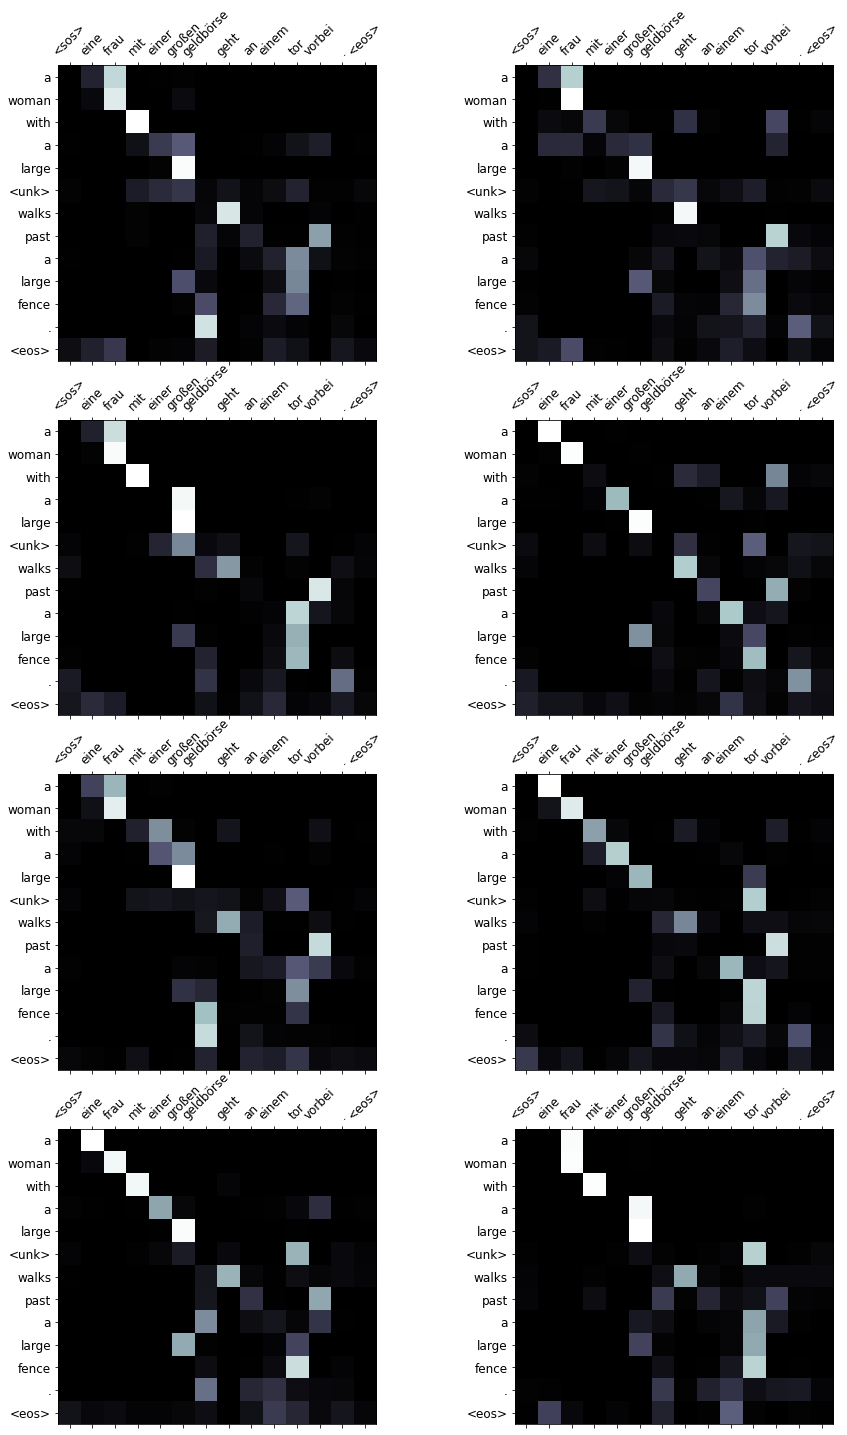

In [ ]:
display_attention(src, translation, attention)

In [ ]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'running', 'the', 'black', 'dog', '.', '<eos>']


In [ ]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'mother', 'and', 'little', 'mother', 'are', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.', '<eos>']


## BLEU SCORE

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 25.68


## Appendix 

The calculate_bleu function above is unoptimized. Below is a significantly faster, vectorized version of it that should be used if needed. Credit for the implementation goes to @azadyasar.

In [ ]:
def translate_sentence_vectorized(src_tensor, src_field, trg_field, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu_alt(iterator, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for batch in iterator:
            src = batch.src
            trg = batch.trg
            _trgs = []
            for sentence in trg:
                tmp = []
                # Start from the first token which skips the <start> token
                for i in sentence[1:]:
                    # Targets are padded. So stop appending as soon as a padding or eos token is encountered
                    if i == trg_field.vocab.stoi[trg_field.eos_token] or i == trg_field.vocab.stoi[trg_field.pad_token]:
                        break
                    tmp.append(trg_field.vocab.itos[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, src_field, trg_field, model, device)
            pred_trgs += pred_trg
    return pred_trgs, trgs, bleu_score(pred_trgs, trgs)